In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.spatial.distance import cdist

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor

In [122]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# EDA

In [243]:
def remove_duplicates(df):
    return df.drop_duplicates()

def deal_missing_value(df):
    return df.drop(columns=['elevation'])

def remove_irrelevant_attributes(df):
    return df.drop(columns=['furnished'])

def standardize_attribute_value(df):
    df['flat_type'] = df['flat_type'].str.replace('-', ' ').str.strip()
    df['street_name'] = df['street_name'].str.lower().strip()
    return df

def create_attributes(df):
  # year and month from rent_approval_date
    df[['rent_approval_year', 'rent_approval_month']] = df['rent_approval_date'].str.split('-', expand=True)
    df['rent_approval_year'] = df['rent_approval_year'].astype(int)
    df['rent_approval_month'] = df['rent_approval_month'].astype(int)

  # house age from subtract rent_approval_year and lease_commence_date
    df['house_age'] = df['rent_approval_year'] - df['lease_commence_date']
    return df

def remove_train_outliers(df):
    # monthly rent <= 1.5IQR
    rent_distribution = df['monthly_rent'].describe()
    IQR = rent_distribution['75%'] - rent_distribution['25%']
    lower_bound = rent_distribution['25%'] - 1.5 * IQR
    return df[df['monthly_rent'] >= lower_bound]

In [15]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees).
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

def count_within_radius(reference_df, target_df, radius=1.0):
    """
    Count the number of points in target_df within the specified radius
    from each point in reference_df.
    """
    count_list = []
    for _, row in reference_df.iterrows():
        distances = haversine(row['latitude'], row['longitude'], target_df['latitude'].values, target_df['longitude'].values)
        count = np.sum(distances < radius)
        count_list.append(count)
    return count_list

def get_facilities(df):
    df['mrt_existing_count_1km'] = count_within_radius(df, mrt_existing)
    df['mrt_planned_count_1km'] = count_within_radius(df, mrt_planned)
    df['primary_schools_count_1km'] = count_within_radius(df, primary_schools)
    df['shopping_malls_count_1km'] = count_within_radius(df, shopping_malls)
    return df

In [19]:
def get_nearest_mrt(df):
    train_coords = df[['latitude', 'longitude']].to_numpy()
    mrt_coords = mrt_existing[['latitude', 'longitude']].to_numpy()
    train_distances = cdist(train_coords, mrt_coords)
    train_min_indices = train_distances.argmin(axis=1)
    df['nearest_mrt_station'] = mrt_existing.iloc[train_min_indices]['name'].values
    df['distance_to_nearest_mrt'] = train_distances.min(axis=1)*1000

    return df

def get_information_mrt(df, mrt_existing):
    mrt_existing = mrt_existing.drop_duplicates(subset='name')
    df = df.merge(mrt_existing[['name', 'code']], left_on='nearest_mrt_station', right_on='name', how='left')
    df['line'] = df['code'].str[:2]
    df['mrt_no'] = df['code'].str[2:]
    df.drop(columns=['code', 'name'], inplace=True)
    return df

def get_monthly_coe_with_cat(coe, cat='a'):
    mask = coe['category'] == cat
    coe_price = coe[mask].copy()
    coe_price['year'] = coe_price['year'].astype(str)
    coe_price['date'] = coe_price['year'] + '-' + coe_price['month'] + '-01'
    coe_price['date'] = pd.to_datetime(coe_price['date'], format='%Y-%B-%d')
    coe_price_mean = coe_price.groupby('date')['price'].mean().reset_index()
    coe_price_mean.rename(columns={'price': 'coe_price'}, inplace=True)
    return coe_price_mean[['date', 'coe_price']]

def link_coe_and_rent(df, coe, cat):
    coe_cat = get_monthly_coe_with_cat(coe, cat)
    merged_df = df.merge(coe_cat, right_on='date', left_on='rent_approval_date', how='left')
    return merged_df.drop(columns = ['date'])

In [104]:
def preprocess_data(df):
    df = remove_duplicates(df)
    df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    df = remove_train_outliers(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    df = get_information_mrt(df, mrt_existing)
    df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date'])
    df = link_coe_and_rent(df, coe_price, 'a')
    return df

def calculate_RMSE(yhat, y):
    return np.sqrt(sum((yhat -y)**2)/len(yhat))

def convert_df_to_numeric(df):
    non_object_sub = df.select_dtypes(exclude=['object'])
    object_sub = df.select_dtypes(include=['object'])
    if object_sub.shape[1]:
        encoded_sub = pd.get_dummies(object_sub)
        return pd.concat([non_object_sub, encoded_sub], axis=1)
    
    return df

def get_csv_for_kaggle(arr, file_name):
    df = pd.DataFrame(arr)
    df.rename(columns={0:'Predicted'}, inplace=True)
    df.to_csv(file_name, index=True, index_label='Id' )

In [27]:
def plot_validation_results(param_to_scores):

    plt.figure()

    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Plot the scores for each fold
    for param, scores in param_to_validation_scores.items():
        plt.scatter([param] * len(scores), scores)

    # Calculate mean and standard variation across all folds for each parameter value
    score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    score_std = np.array([np.std(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.errorbar(sorted(param_to_validation_scores.keys()), score_mean, yerr=score_std)
    
    plt.xlabel('param')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()
    

def plot_scores(param_to_scores):

    plt.figure()

    param_to_training_scores = {k: scores[0] for (k, scores) in param_to_scores.items()}
    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Calculate mean and standard variation across all folds for each parameter value
    training_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_training_scores.items())])
    validation_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.plot(sorted(param_to_training_scores.keys()), training_score_mean, label ='Training Score')
    plt.plot(sorted(param_to_validation_scores.keys()), validation_score_mean, label ='Validation Score')
    plt.legend(loc='lower right') 
    
    plt.xlabel('param')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()         


## Macroeconomy

In [2]:
stock_price = pd.read_csv('sg-stock-prices.csv')
coe_price = pd.read_csv('sg-coe-prices.csv')
train = pd.read_csv("train.csv")

In [4]:
plot_df = train.copy()
plot_df['rent_approval_date'] = pd.to_datetime(plot_df['rent_approval_date'])
plot_df['rent_per_sqm'] = plot_df['monthly_rent']/plot_df['floor_area_sqm']

In [5]:
coe_price['year'] = coe_price['year'].astype(str)
coe_price['date'] = coe_price['year'] + '-' + coe_price['month'] + '-01'
coe_price['date'] = pd.to_datetime(coe_price['date'], format='%Y-%B-%d')

In [6]:
stock_price['date'] = pd.to_datetime(stock_price['date'])
stock_price_count = stock_price.groupby('symbol')['adjusted_close'].count().reset_index()
selected_stock = list(stock_price_count[stock_price_count['adjusted_close'] == 646]['symbol'].unique())
selected_stock_df = stock_price[stock_price['symbol'].isin(selected_stock)]
average_stock_price = selected_stock_df.groupby(selected_stock_df['date'].dt.to_period('M'))['adjusted_close'].mean().reset_index()
average_stock_price['date'] = average_stock_price['date'].astype(str)
average_stock_price['date'] = average_stock_price['date'] + '-01'
average_stock_price['date'] = pd.to_datetime(average_stock_price['date'])

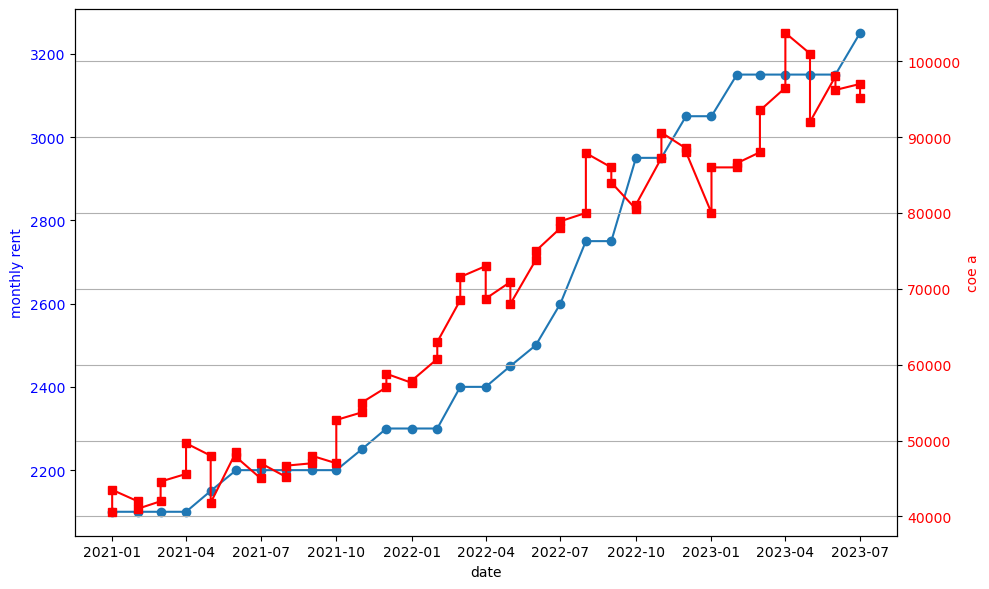

In [7]:
fig, ax1 = plt.subplots(figsize=(10,6))
median_rent = plot_df.groupby('rent_approval_date')['monthly_rent'].median().reset_index()
ax1.plot(median_rent['rent_approval_date'], median_rent['monthly_rent'], label='rent', marker='o')
ax1.set_xlabel('date')
ax1.set_ylabel('monthly rent', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
coe_mask = coe_price['category'] == 'a'
ax2.plot(coe_price[coe_mask]['date'], coe_price[coe_mask]['price'], label='coe a', marker='s', color='r')
ax2.set_ylabel('coe a', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.grid(True)
plt.tight_layout()
plt.show()

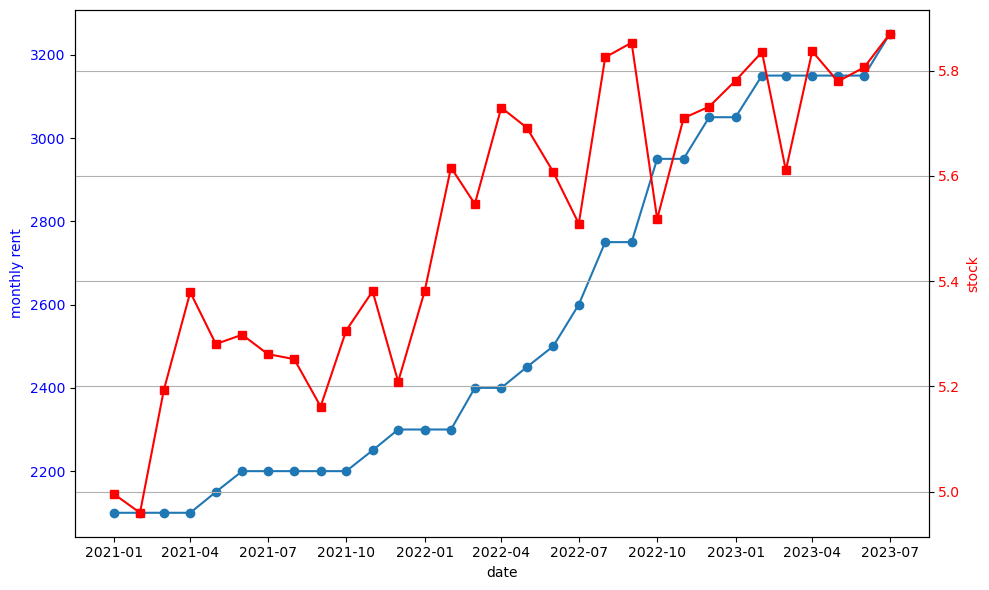

In [10]:
fig, ax1 = plt.subplots(figsize=(10,6))
median_rent = plot_df.groupby('rent_approval_date')['monthly_rent'].median().reset_index()
ax1.plot(median_rent['rent_approval_date'], median_rent['monthly_rent'], label='rent', marker='o')
ax1.set_xlabel('date')
ax1.set_ylabel('monthly rent', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(average_stock_price['date'], average_stock_price['adjusted_close'], label='stock', color='r', marker='s')
ax2.set_ylabel('stock', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.grid(True)
plt.tight_layout()
plt.show()

# Preliminary Model

In [11]:
mrt_existing = pd.read_csv('sg-mrt-existing-stations.csv')
mrt_planned = pd.read_csv('sg-mrt-planned-stations.csv')
primary_schools = pd.read_csv('sg-primary-schools.csv')
shopping_malls = pd.read_csv('sg-shopping-malls.csv')
stock_price = pd.read_csv('sg-stock-prices.csv')
coe_price = pd.read_csv('sg-coe-prices.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

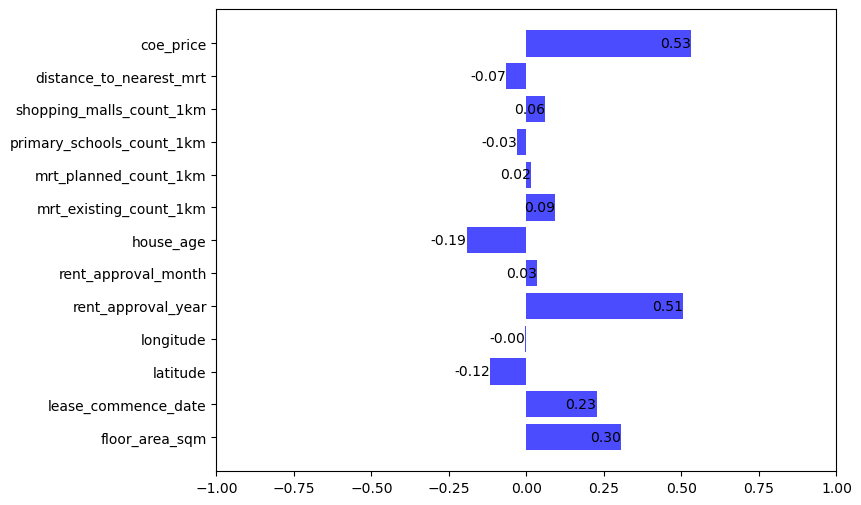

In [20]:
plot_df = preprocess_data(train)
numerical_df = plot_df.select_dtypes(include=['int64', 'float64'])
correlations = numerical_df.corr()['monthly_rent'].drop('monthly_rent')
plt.figure(figsize=(8, 6))
bars = plt.barh(correlations.index, correlations.values, color='b', alpha=0.7)
plt.xlim(-1, 1)

for bar, correlation in zip(bars, correlations.values):
    plt.text(correlation, bar.get_y() + bar.get_height() / 2, f'{correlation:.2f}', ha='right', va='center')
plt.show()

In [24]:
%%time
processed_train = preprocess_data(train)

CPU times: user 35.8 s, sys: 215 ms, total: 36 s
Wall time: 36.1 s


In [160]:
FEATURES = [
    'town', 
    'subzone',
    'flat_type', 
    'line',
    'floor_area_sqm', 
    'lease_commence_date', 
    'rent_approval_year', 
    'house_age', 
    'flat_model',
    'mrt_existing_count_1km', 
    'mrt_planned_count_1km',
    'nearest_mrt_station', 
    'distance_to_nearest_mrt',  
]
df_X = convert_df_to_numeric(processed_train[FEATURES])
df_y = processed_train['monthly_rent']
df_X = df_X.to_numpy()
df_y = df_y.to_numpy()

In [29]:
%%time

param_choices = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50]
param_to_scores = {}

for param in param_choices:
    regressor = DecisionTreeRegressor(max_depth=param)
    scores = cross_validate(regressor, df_X, df_y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    rsme_train = scores['train_score'] * (-1)
    rsme_valid = scores['test_score'] * (-1)
    param_to_scores[param] = (rsme_train, rsme_valid)
  
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

param = 1, RSME training = 643.0 (0.7), RSME validation = 643.6 (6.0)
param = 2, RSME training = 597.2 (1.2), RSME validation = 597.5 (6.4)
param = 3, RSME training = 564.5 (0.8), RSME validation = 564.8 (7.2)
param = 5, RSME training = 541.0 (0.9), RSME validation = 543.2 (5.8)
param = 10, RSME training = 503.4 (0.9), RSME validation = 528.5 (5.7)
param = 15, RSME training = 467.2 (1.4), RSME validation = 546.1 (9.1)
param = 20, RSME training = 429.3 (2.4), RSME validation = 575.0 (9.7)
param = 30, RSME training = 370.9 (4.6), RSME validation = 618.6 (9.8)
param = 40, RSME training = 344.9 (2.9), RSME validation = 637.0 (7.9)
param = 50, RSME training = 339.8 (1.2), RSME validation = 639.0 (6.8)
CPU times: user 5min 24s, sys: 4.43 s, total: 5min 29s
Wall time: 5min 31s


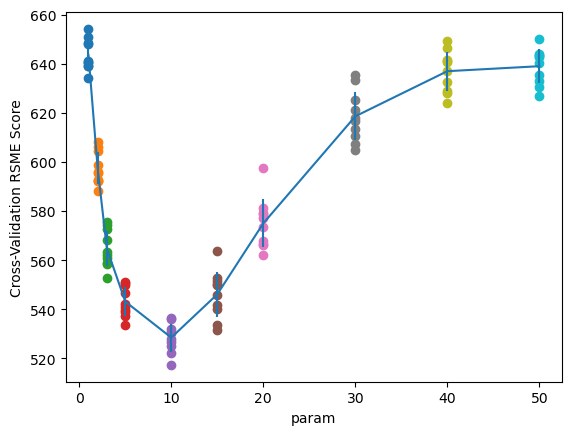

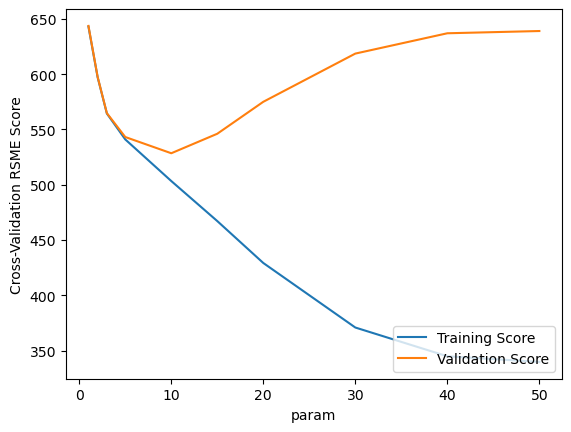

In [30]:
plot_validation_results(param_to_scores)
plot_scores(param_to_scores)

In [162]:
%%time

param_choices = [1, 2, 3, 5, 10, 15, 20, 30]
param_to_scores = {}

for param in param_choices:
    regressor = RandomForestRegressor(max_depth=param)
    scores = cross_validate(regressor, df_X, df_y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    rsme_train = scores['train_score'] * (-1)
    rsme_valid = scores['test_score'] * (-1)
    param_to_scores[param] = (rsme_train, rsme_valid)
  
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))


param = 1, RSME training = 626.0 (3.2), RSME validation = 626.4 (8.1)
param = 2, RSME training = 583.6 (1.4), RSME validation = 583.7 (6.7)
param = 3, RSME training = 562.3 (0.8), RSME validation = 562.5 (7.0)
param = 5, RSME training = 536.2 (0.7), RSME validation = 538.1 (5.7)
param = 10, RSME training = 495.5 (0.6), RSME validation = 515.8 (5.6)
param = 15, RSME training = 456.8 (0.7), RSME validation = 517.4 (6.2)
param = 20, RSME training = 420.0 (0.9), RSME validation = 527.9 (6.4)
param = 30, RSME training = 374.0 (1.1), RSME validation = 551.1 (6.0)
CPU times: user 1h 51min 53s, sys: 29.6 s, total: 1h 52min 23s
Wall time: 1h 52min 59s


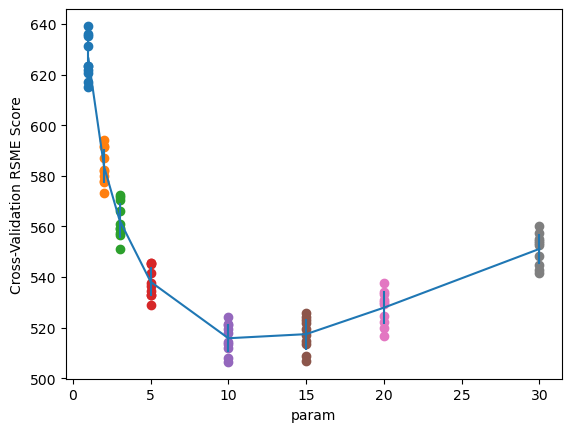

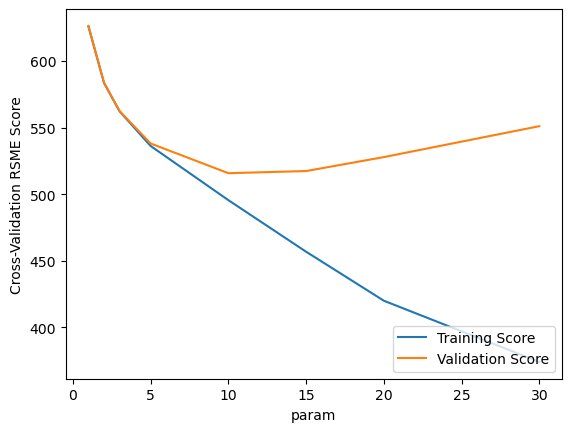

In [163]:
plot_validation_results(param_to_scores)
plot_scores(param_to_scores)

In [161]:
%%time

param_choices = [1, 2, 3, 5, 10, 15]
param_to_scores = {}

for param in param_choices:
    regressor = GradientBoostingRegressor(max_depth=param)
    scores = cross_validate(regressor, df_X, df_y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    rsme_train = scores['train_score'] * (-1)
    rsme_valid = scores['test_score'] * (-1)
    param_to_scores[param] = (rsme_train, rsme_valid)
  
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

param = 1, RSME training = 540.7 (0.6), RSME validation = 541.1 (5.8)
param = 2, RSME training = 517.3 (0.6), RSME validation = 519.0 (5.4)
param = 3, RSME training = 507.8 (0.7), RSME validation = 511.4 (5.5)
param = 5, RSME training = 494.4 (0.8), RSME validation = 506.6 (5.7)
param = 10, RSME training = 442.7 (1.1), RSME validation = 516.2 (6.1)
param = 15, RSME training = 379.9 (1.7), RSME validation = 549.7 (7.9)
CPU times: user 2h 11min 2s, sys: 21.4 s, total: 2h 11min 24s
Wall time: 2h 11min 44s


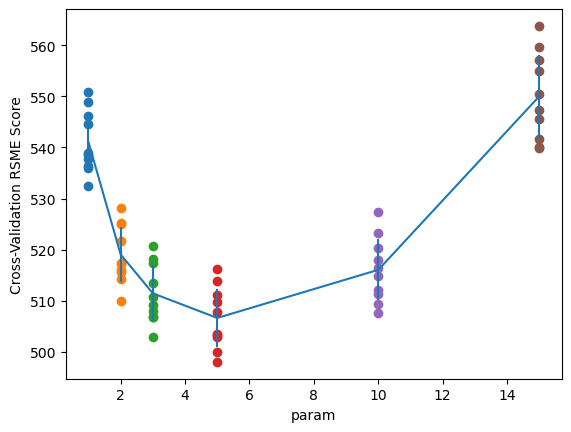

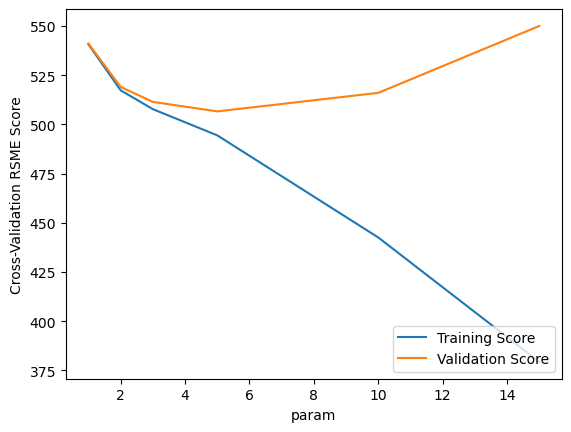

In [34]:
plot_validation_results(param_to_scores)
plot_scores(param_to_scores)

## Evaluation of GB model with max depth = 5

### Feature importance

In [35]:
processed_train = preprocess_data(train)

In [36]:
FEATURES = [
    'town', 
    'subzone',
    'flat_type', 
    'line',
    'floor_area_sqm', 
    'lease_commence_date', 
    'rent_approval_year', 
    'house_age', 
    'flat_model',
    'mrt_existing_count_1km', 
    'mrt_planned_count_1km',
    'nearest_mrt_station', 
    'distance_to_nearest_mrt', 
    'coe_price',
]
df_X = convert_df_to_numeric(processed_train[FEATURES])
df_y = processed_train['monthly_rent']
train_X = df_X.to_numpy()
train_y = df_y.to_numpy()

In [37]:
%%time
gb_5_regressor = GradientBoostingRegressor(max_depth=5)
gb_5_regressor.fit(train_X, train_y)

CPU times: user 46.4 s, sys: 134 ms, total: 46.5 s
Wall time: 46.6 s


GradientBoostingRegressor(max_depth=5)

In [38]:
feature_importances = gb_5_regressor.feature_importances_
feature_names = df_X.columns
feature_dict = dict(zip(feature_names, feature_importances))

In [42]:
sorted_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1]))
sorted_dict

{'town_hougang': 0.0,
 'town_pasir ris': 0.0,
 'subzone_alexandra hill': 0.0,
 'subzone_aljunied': 0.0,
 'subzone_anchorvale': 0.0,
 'subzone_balestier': 0.0,
 'subzone_bangkit': 0.0,
 'subzone_bedok reservoir': 0.0,
 'subzone_bedok south': 0.0,
 'subzone_bencoolen': 0.0,
 'subzone_boon teck': 0.0,
 'subzone_braddell': 0.0,
 'subzone_brickworks': 0.0,
 'subzone_bugis': 0.0,
 'subzone_bukit batok east': 0.0,
 'subzone_bukit batok west': 0.0,
 'subzone_bukit ho swee': 0.0,
 'subzone_bukit merah': 0.0,
 'subzone_china square': 0.0,
 'subzone_choa chu kang central': 0.0,
 'subzone_city hall': 0.0,
 'subzone_clementi central': 0.0,
 'subzone_clementi west': 0.0,
 'subzone_clementi woods': 0.0,
 'subzone_compassvale': 0.0,
 'subzone_crawford': 0.0,
 'subzone_dover': 0.0,
 'subzone_farrer park': 0.0,
 'subzone_fernvale': 0.0,
 'subzone_frankel': 0.0,
 'subzone_geylang east': 0.0,
 'subzone_ghim moh': 0.0,
 'subzone_gombak': 0.0,
 'subzone_holland drive': 0.0,
 'subzone_hong kah north': 0.0,
 

### Residual Analysis

In [47]:
%%time
y_train_hat = gb_5_regressor.predict(train_X)

CPU times: user 1.24 s, sys: 46.2 ms, total: 1.29 s
Wall time: 1.29 s


In [48]:
evaluation= processed_train.copy()
evaluation['prediction'] = y_train_hat
evaluation['residual'] = evaluation['prediction'] - evaluation['monthly_rent']

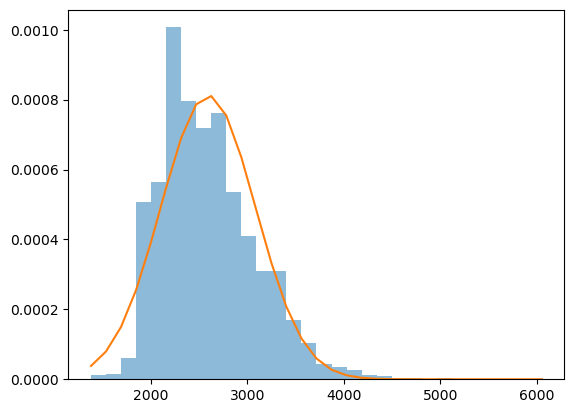

In [52]:
_, bins, _ = plt.hist(evaluation['prediction'], 30, density=1, alpha=0.5)

mu, sigma = scipy.stats.norm.fit(evaluation['prediction'])
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

plt.show()

In [ ]:
sorted_residuals = evaluation[['residual']].sort_values(by='residual', ascending=False)
top3_indices = sorted_residuals.index[:3]
sm.qqplot(sorted_residuals['residual'], line='45', fit=True)
plt.title('Quantile-quantile plot of residuals')
for idx in top3_indices:
    x = sm.ProbPlot(sorted_residuals['residual'])
    y = x.quantiles
    y_val = sorted_residuals[idx]
    x_val = y[y == y_val].index[0]
    plt.annotate(f'{idx}', (x_val, y_val), textcoords='offset points', xytest=(0, 10), ha='center')
plt.show()

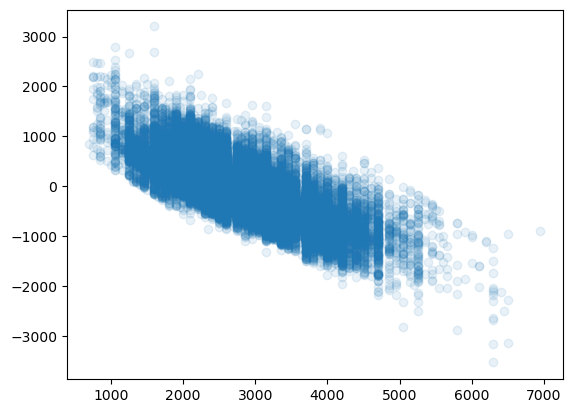

In [53]:
x = evaluation['monthly_rent']
y = evaluation['residual']
slope, intercept = np.polyfit(x, y, 1)

plt.scatter(evaluation['monthly_rent'], evaluation['residual'], alpha=0.1)
plt.plot(x, slopt*x + intercept, color='red')

plt.show()

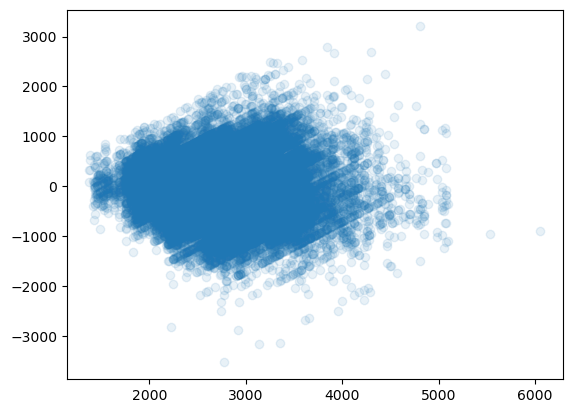

In [54]:
plt.scatter(evaluation['prediction'], evaluation['residual'], alpha=0.1)
plt.show()

In [64]:
evaluation.sort_values(by='residual', ascending=False).head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,...,mrt_planned_count_1km,primary_schools_count_1km,shopping_malls_count_1km,nearest_mrt_station,distance_to_nearest_mrt,line,mrt_no,coe_price,prediction,residual
624,2023-06-01,central,1c,cantonment road,4 room,type s1,93.0,2011,1.277449,103.841667,...,2,1,4,Outram Park,3.225613,EW,16,97103.5,4802.450078,3202.450078
28372,2023-04-01,bukit merah,6b,boon tiong road,4 room,model a,91.0,2005,1.286546,103.830824,...,0,2,2,Havelock,3.385814,TE,16,100111.0,3839.814672,2789.814672
38677,2023-03-01,queenstown,89,dawson road,4 room,premium apartment loft,95.0,2016,1.295463,103.811785,...,0,1,1,Queenstown,5.780529,EW,19,90751.5,4293.683056,2693.683056
25397,2023-02-01,bukit merah,25a,Jalan Membina,4 room,model a,90.0,2008,1.283466,103.826183,...,0,4,1,Tiong Bahru,2.847489,EW,17,86278.0,3914.194017,2664.194017
27242,2023-03-01,bishan,235,bishan street 22,5 room,model a,132.0,1992,1.358588,103.846536,...,1,4,2,Bishan,8.348056,NS,17,90751.5,3582.145699,2532.145699


In [61]:
evaluation.iloc[28372]

rent_approval_date           2023-04-01 00:00:00
town                                 bukit merah
block                                         6b
street_name                      boon tiong road
flat_type                                 4 room
flat_model                               model a
floor_area_sqm                              91.0
lease_commence_date                         2005
latitude                                1.286546
longitude                             103.830824
subzone                              tiong bahru
planning_area                        bukit merah
region                            central region
monthly_rent                                1050
rent_approval_year                          2023
rent_approval_month                            4
house_age                                     18
mrt_existing_count_1km                         3
mrt_planned_count_1km                          0
primary_schools_count_1km                      2
shopping_malls_count

In [65]:
evaluation.sort_values(by='residual', ascending=True).head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,...,mrt_planned_count_1km,primary_schools_count_1km,shopping_malls_count_1km,nearest_mrt_station,distance_to_nearest_mrt,line,mrt_no,coe_price,prediction,residual
49342,2022-10-01,bukit merah,27,lim liak street,3 room,standard,75.0,1973,1.285437,103.830839,...,0,2,2,Tiong Bahru,3.914404,EW,17,80795.0,2770.023244,-3529.976756
29061,2023-05-01,jurong west,457,jurong west street 41,4 room,model a,102.0,1984,1.350698,103.720905,...,2,2,0,Lakeside,6.439260,EW,26,96500.5,3140.757294,-3159.242706
49959,2022-11-01,bukit merah,35,lim liak street,3 room,standard,88.0,1973,1.285102,103.831035,...,0,1,2,Tiong Bahru,4.181561,EW,17,88912.0,3355.435756,-3144.564244
42715,2022-11-01,hougang,539,hougang street 52,executive,maisonette,147.0,1992,1.377480,103.890340,...,1,6,3,Buangkok,6.779545,NE,15,88912.0,2916.562558,-2883.437442
33251,2022-10-01,jurong west,501,jurong west street 51,3 room,model a,74.0,1986,1.350384,103.719026,...,1,2,1,Lakeside,6.419959,EW,26,80795.0,2226.339540,-2823.660460


In [66]:
evaluation.iloc[49959]

rent_approval_date           2022-11-01 00:00:00
town                                 bukit merah
block                                         35
street_name                      lim liak street
flat_type                                 3 room
flat_model                              standard
floor_area_sqm                              88.0
lease_commence_date                         1973
latitude                                1.285102
longitude                             103.831035
subzone                              tiong bahru
planning_area                        bukit merah
region                            central region
monthly_rent                                6500
rent_approval_year                          2022
rent_approval_month                           11
house_age                                     49
mrt_existing_count_1km                         2
mrt_planned_count_1km                          0
primary_schools_count_1km                      1
shopping_malls_count

# Final Model

In [67]:
def apply_target_encoding(df, target):
    target_median_price = df.groupby(target)['monthly_rent'].median().reset_index()
    target_dict = target_median_price.set_index(target)['monthly_rent'].to_dict()
    target_dict['unknown'] = df['monthly_rent'].median()
    target_median_price.rename(columns={'monthly_rent': f'encoded_median_rent_by_{target}'}, inplace=True)
    merged_df = df.merge(target_median_price, on=target, how='left')

    return target_dict, merged_df

def encode_test_set(df, target, target_dict):
    df = df.copy()
    df[f'encoded_median_rent_by_{target}'] = df[target].map(target_dict)
    missing_index = df[~df[target].isin(target_dict)].index
    if not missing_index.empty:
        df.loc[missing_index, f'encoded_median_rent_by_{target}'] = target_dict['unknown']
    df.drop(columns=[target], inplace=True)
    return df

### target encoding

In [68]:
mrt_existing = pd.read_csv('sg-mrt-existing-stations.csv')
mrt_planned = pd.read_csv('sg-mrt-planned-stations.csv')
primary_schools = pd.read_csv('sg-primary-schools.csv')
shopping_malls = pd.read_csv('sg-shopping-malls.csv')
stock_price = pd.read_csv('sg-stock-prices.csv')
coe_price = pd.read_csv('sg-coe-prices.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [249]:
encoded_df = preprocess_data(train)

In [250]:
def get_residual(df, target, y='monthly_rent'):
    rmse = []
    skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    for train, test in skf.split(df, df['monthly_rent']):
        train_x = df.iloc[train]
        median_rent_by_target = train_x.groupby(target)[y].mean().reset_index()
        median_rent_by_target.rename(columns={y: 'mean_rent'}, inplace=True)
        
        test_x = df.iloc[test]
        test_x = test_x.merge(median_rent_by_target, on=target, how='left')
        if y == 'rent_per_sqm':
            test_x['residual'] = (test_x[y] - test_x['mean_rent'])*test_x['floor_area_sqm']
        else:
            test_x['residual'] = (test_x[y] - test_x['mean_rent'])
        rmse.append(np.sqrt(np.sum(test_x['residual']**2)/ len(test_x)))
    return np.mean(rmse)

In [251]:
object_sub = encoded_df.select_dtypes(include=['object'])
residual_dict= {}
for target in object_sub:
    residual_dict[target] = get_residual(encoded_df, target)

In [252]:
residual_dict

{'town': 697.9604863101677,
 'block': 697.0625612719014,
 'street_name': 666.4106759803414,
 'flat_type': 670.004248951794,
 'flat_model': 693.3876791888597,
 'subzone': 677.404355730716,
 'planning_area': 696.7734627203557,
 'region': 707.7688536951393,
 'nearest_mrt_station': 689.2890011818482,
 'line': 709.1234648353955,
 'mrt_no': 703.5939377739298}

### Feature extraction

In [130]:
def add_new_features(df):
    feature_list = []
    subzones = ['toh guan', 'jurong west', 'marine parade', 'margaret drive', 'chinatown', 'macpherson', 'marymount', 'tiong bahru']
    for zone in subzones:
        zone_column = 'subzone_' + zone
        feature_list.append(zone_column)
        df[zone_column] = 0
        df.loc[df['subzone'] == zone, zone_column] = 1
    
    nearest_mrt = ['Bishan', 'Ang Mo Kio', 'Serangoon', 'Queestown', 'Sembawang', 'Commonwealth', 'Toa Payoh', 'Bedok']
    for mrt in nearest_mrt:
        mrt_column = 'mrt_' + mrt
        feature_list.append(mrt_column)
        df[mrt_column] = 0
        df.loc[df['nearest_mrt_station'] == mrt, mrt_column] = 1
        
    
    mask = (df['region'] == 'central region') & (df['flat_model'].isin(['maisonette', 'type s1', 'type s2', '3gen']))
    feature_list.append('central_and_large')
    df['central_and_large'] = 0
    df.loc[mask, 'central_and_large'] = 1
        
    return df, feature_list

In [198]:
def get_rmse(features, df, target='street_name', param=5, n=100):
    
    df_X = df[features]
    df_y = df['monthly_rent']
      
    skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    regressor = GradientBoostingRegressor(max_depth=param, n_estimators=n)
    #regressor = DecisionTreeRegressor(max_depth=5) # testing
    rmse_cv_list = []
    rmse_train_list = []
    for train_set, test_set in skf.split(df_X, df_y):
        X_train = df_X.iloc[train_set]
        y_train = df_y.iloc[train_set]
        train_sub = pd.concat([X_train, y_train], axis=1)
        target_dict, encoded_train = apply_target_encoding(train_sub, target)
        encoded_train.drop(columns=[target], inplace=True)
        encoded_train.drop(columns=['monthly_rent'], inplace=True)
        numerical_train = convert_df_to_numeric(encoded_train)
        array_train_X = numerical_train.to_numpy()
        array_train_y = y_train.to_numpy()
        
        regressor.fit(array_train_X, array_train_y)
        
        X_test = df_X.iloc[test_set]
        y_test = df_y.iloc[test_set]
        encoded_test = encode_test_set(X_test, target, target_dict)
        numerical_test = convert_df_to_numeric(encoded_test)
        if len(numerical_test.columns) != len(numerical_train.columns):
            columns_only_in_train = set(numerical_train.columns) - set(numerical_test.columns)
            for col in columns_only_in_train:
                numerical_test[col] = False
        
        array_test_X = numerical_test.to_numpy()
        array_test_y = y_test.to_numpy()
        
        y_hat = regressor.predict(array_test_X)
        rmse_cv_list.append(calculate_RMSE(y_hat, array_test_y))
        
        y_hat_train = regressor.predict(array_train_X)
        rmse_train_list.append(calculate_RMSE(y_hat_train, array_train_y))
    #print(f'features={features}, rmse_train={np.mean(rmse_train_list):.3f}, rmse_cv={np.mean(rmse_cv_list):.3f}')
    return np.mean(rmse_cv_list), np.std(rmse_cv_list)

In [132]:
mrt_existing = pd.read_csv('sg-mrt-existing-stations.csv')
mrt_planned = pd.read_csv('sg-mrt-planned-stations.csv')
primary_schools = pd.read_csv('sg-primary-schools.csv')
shopping_malls = pd.read_csv('sg-shopping-malls.csv')
stock_price = pd.read_csv('sg-stock-prices.csv')
coe_price = pd.read_csv('sg-coe-prices.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [157]:
%%time
processed_train = preprocess_data(train)
add_feature_train = processed_train.copy()
add_feature_train, new_features = add_new_features(processed_train)

CPU times: user 36.2 s, sys: 189 ms, total: 36.4 s
Wall time: 36.5 s


In [156]:
FEATURES = [
    'mrt_existing_count_1km',
    'lease_commence_date',
    'house_age',
    'town',
    'line',
    'floor_area_sqm',
    'flat_model',
    'flat_type',
    'latitude',
    'coe_price',
    'mrt_planned_count_1km', 
    'distance_to_nearest_mrt',
] + new_features

SELECTED_FEATURES = ['rent_approval_year', 'street_name']

In [159]:
THRESHOLD = 0.05
rmse_record = [10000]
improvement = 10000

while improvement >= THRESHOLD and len(FEATURES) > 0 :
    potential_features = [feature for feature in FEATURES if not feature in SELECTED_FEATURES]
    rmse_list = []
    for feature in potential_features:
        current_features = SELECTED_FEATURES + [feature]
        rmse, sigma = get_rmse(current_features, add_feature_train)
        rmse_list.append(rmse)
 
    rmse_array = np.array(rmse_list)
    min_rmse = np.min(rmse_array)
    selected_feature = potential_features[np.argmin(rmse_array)]
    if min_rmse < rmse_record[-1]:
        improvement = rmse_record[-1] - min_rmse 
        rmse_record.append(min_rmse)
        SELECTED_FEATURES.append(selected_feature)
        FEATURES.remove(selected_feature)
        print(f'SELECTED FEATURES = {SELECTED_FEATURES}, RMSE = {rmse_record}')
    else:
        break
        

/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm'], RMSE = [10000, 527.3156204716289]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price'], RMSE = [10000, 527.3156204716289, 507.0418999632907]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town', 'lease_commence_date'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719, 491.54854224428243]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town', 'lease_commence_date', 'latitude'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719, 491.54854224428243, 488.9218757737849]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town', 'lease_commence_date', 'latitude', 'distance_to_nearest_mrt'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719, 491.54854224428243, 488.9218757737849, 487.5240657037555]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town', 'lease_commence_date', 'latitude', 'distance_to_nearest_mrt', 'flat_type'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719, 491.54854224428243, 488.9218757737849, 487.5240657037555, 486.5544755880104]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town', 'lease_commence_date', 'latitude', 'distance_to_nearest_mrt', 'flat_type', 'subzone_margaret drive'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719, 491.54854224428243, 488.9218757737849, 487.5240657037555, 486.5544755880104, 486.3770653667534]


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SELECTED FEATURES = ['rent_approval_year', 'street_name', 'floor_area_sqm', 'coe_price', 'town', 'lease_commence_date', 'latitude', 'distance_to_nearest_mrt', 'flat_type', 'subzone_margaret drive', 'mrt_Bishan'], RMSE = [10000, 527.3156204716289, 507.0418999632907, 495.8965836514719, 491.54854224428243, 488.9218757737849, 487.5240657037555, 486.5544755880104, 486.3770653667534, 486.37443240361443]


## Fine Tuning

### Stricter outlier removal

In [169]:
def preprocess_test_data(df):
    #df = remove_duplicates(df)
    #df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    #df = remove_train_outliers(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    df = get_information_mrt(df, mrt_existing)
    return df

In [170]:
def remove_more_outliers(df, target, constant=1.5):
    rent_by_target = df.groupby(target)['monthly_rent'].describe().reset_index()
    rent_by_target['IQR'] =rent_by_target['75%'] - rent_by_target['25%']
    rent_by_target['lower_bound'] = rent_by_target['50%'] - constant*rent_by_target['IQR']

    df_difference = df.merge(rent_by_target[[target, 'lower_bound']], on=target, how='left')
    mask = (df_difference['monthly_rent']>=df_difference['lower_bound'])
    return df_difference[mask]

In [171]:
FEATURES = [
    'rent_approval_year', 
    'street_name', 
    'floor_area_sqm', 
    'coe_price', 
    'town', 
    'lease_commence_date', 
    'latitude', 
    'distance_to_nearest_mrt', 
    'flat_type', 
    'subzone_margaret drive', 
    'mrt_Bishan',
]
target = 'street_name'

In [177]:
%%time
processed_train = preprocess_data(train)
add_feature_train, _ = add_new_features(processed_train)

CPU times: user 37.5 s, sys: 284 ms, total: 37.8 s
Wall time: 38.1 s


In [178]:
ref_train = add_feature_train.copy()
less_train = remove_more_outliers(add_feature_train, target='flat_type', constant=0.8)

In [179]:
%%time

ref_X = ref_train[FEATURES]
ref_y = ref_train['monthly_rent']
ref_regressor = GradientBoostingRegressor(max_depth=5)

X_train = ref_X.copy()
y_train = ref_y.copy()
train_sub = pd.concat([X_train, y_train], axis=1)
target_dict, encoded_train = apply_target_encoding(train_sub, target)
encoded_train.drop(columns=[target, 'monthly_rent'], inplace=True)
        
numerical_train = convert_df_to_numeric(encoded_train)
array_train_X = numerical_train.to_numpy()
array_train_y = y_train.to_numpy()
    
# train
ref_regressor.fit(array_train_X, array_train_y)
    
# process test set
X_test = preprocess_test_data(test)
X_test['rent_approval_date'] = pd.to_datetime(X_test['rent_approval_date'])
X_test = link_coe_and_rent(X_test, coe_price, 'a')
X_test, _ = add_new_features(X_test)
X_test = X_test[FEATURES]

encoded_test = encode_test_set(X_test, target, target_dict)
numerical_test = convert_df_to_numeric(encoded_test)
array_test_X = numerical_test.to_numpy()

# prediction
y_hat = ref_regressor.predict(array_test_X)
get_csv_for_kaggle(y_hat, f'prediction_final_ref.csv')

CPU times: user 34.4 s, sys: 253 ms, total: 34.7 s
Wall time: 35.1 s


RMSE_test = 484.07654

In [180]:
%%time
less_X = less_train[FEATURES]
less_y = less_train['monthly_rent']
less_regressor = GradientBoostingRegressor(max_depth=5)

X_train = less_X.copy()
y_train = less_y.copy()
train_sub = pd.concat([X_train, y_train], axis=1)
target_dict, encoded_train = apply_target_encoding(train_sub, target)
encoded_train.drop(columns=[target, 'monthly_rent'], inplace=True)
        
numerical_train = convert_df_to_numeric(encoded_train)
array_train_X = numerical_train.to_numpy()
array_train_y = y_train.to_numpy()
    
# train
less_regressor.fit(array_train_X, array_train_y)
    
# process test set
X_test = preprocess_test_data(test)
X_test['rent_approval_date'] = pd.to_datetime(X_test['rent_approval_date'])
X_test = link_coe_and_rent(X_test, coe_price, 'a')
X_test, _ = add_new_features(X_test)
X_test = X_test[FEATURES]

encoded_test = encode_test_set(X_test, target, target_dict)
numerical_test = convert_df_to_numeric(encoded_test)
array_test_X = numerical_test.to_numpy()

# prediction
y_hat = less_regressor.predict(array_test_X)
get_csv_for_kaggle(y_hat, f'prediction_final_less.csv')

CPU times: user 34.1 s, sys: 230 ms, total: 34.4 s
Wall time: 34.6 s


RMSE_test = 485.18325

### Ordinal vs Categorical

In [181]:
def get_ordinal_feature(df, target='town'):
    median_by_target = df.groupby(target)['monthly_rent'].median().reset_index().sort_values(by='monthly_rent')
    median_by_target['rank'] = range(1, len(median_by_target) + 1)
    target_dict = median_by_target.set_index(target)['rank'].to_dict()
    df_mapped = df.copy()
    df_mapped[target] = df[target].map(target_dict)
    return df_mapped, target_dict

def order_test_set(df, d, target='town'):
    df[target] = df[target].map(d)
    return df

In [182]:
FEATURES = [
    'rent_approval_year', 
    'street_name', 
    'floor_area_sqm', 
    'coe_price', 
    'town', 
    'lease_commence_date', 
    'latitude', 
    'distance_to_nearest_mrt', 
    'flat_type', 
    'subzone_margaret drive', 
    'mrt_Bishan',
]
target = 'street_name'

In [183]:
%%time
processed_train = preprocess_data(train)
add_feature_train, _ = add_new_features(processed_train)

CPU times: user 35.9 s, sys: 120 ms, total: 36 s
Wall time: 36.1 s


In [184]:
ref_train = add_feature_train.copy()
ordinal_train, ordinal_dict = get_ordinal_feature(add_feature_train, 'town')

In [185]:
%%time

ref_X = ref_train[FEATURES]
ref_y = ref_train['monthly_rent']
ref_regressor = GradientBoostingRegressor(max_depth=5)

X_train = ref_X.copy()
y_train = ref_y.copy()
train_sub = pd.concat([X_train, y_train], axis=1)
target_dict, encoded_train = apply_target_encoding(train_sub, target)
encoded_train.drop(columns=[target, 'monthly_rent'], inplace=True)
        
numerical_train = convert_df_to_numeric(encoded_train)
array_train_X = numerical_train.to_numpy()
array_train_y = y_train.to_numpy()
    
# train
ref_regressor.fit(array_train_X, array_train_y)
    
# process test set
X_test = preprocess_test_data(test)
X_test['rent_approval_date'] = pd.to_datetime(X_test['rent_approval_date'])
X_test = link_coe_and_rent(X_test, coe_price, 'a')
X_test, _ = add_new_features(X_test)
X_test = X_test[FEATURES]

encoded_test = encode_test_set(X_test, target, target_dict)
numerical_test = convert_df_to_numeric(encoded_test)
array_test_X = numerical_test.to_numpy()

# prediction
y_hat = ref_regressor.predict(array_test_X)
get_csv_for_kaggle(y_hat, f'prediction_final_ref.csv')

CPU times: user 34.4 s, sys: 195 ms, total: 34.6 s
Wall time: 34.8 s


RMSE_test = 484.07654

In [186]:
%%time
ordinal_X = ordinal_train[FEATURES]
ordinal_y = ordinal_train['monthly_rent']
ordinal_regressor = GradientBoostingRegressor(max_depth=5)

X_train = ordinal_X.copy()
y_train = ordinal_y.copy()
train_sub = pd.concat([X_train, y_train], axis=1)
target_dict, encoded_train = apply_target_encoding(train_sub, target)
encoded_train.drop(columns=[target, 'monthly_rent'], inplace=True)
        
numerical_train = convert_df_to_numeric(encoded_train)
array_train_X = numerical_train.to_numpy()
array_train_y = y_train.to_numpy()
    
# train
ordinal_regressor.fit(array_train_X, array_train_y)
    
# process test set
X_test = preprocess_test_data(test)
X_test['rent_approval_date'] = pd.to_datetime(X_test['rent_approval_date'])
X_test = link_coe_and_rent(X_test, coe_price, 'a')
X_test, _ = add_new_features(X_test)
X_test = X_test[FEATURES]

X_test = order_test_set(X_test, ordinal_dict, 'town')
encoded_test = encode_test_set(X_test, target, target_dict)
numerical_test = convert_df_to_numeric(encoded_test)
array_test_X = numerical_test.to_numpy()

# prediction
y_hat = ordinal_regressor.predict(array_test_X)
get_csv_for_kaggle(y_hat, f'prediction_final_ordinal.csv')

CPU times: user 30.4 s, sys: 84.4 ms, total: 30.5 s
Wall time: 30.5 s


RMSE_test = 484.96713

### Hyperparameter Tuning

In [195]:
processed_train = preprocess_data(train)
add_feature_train, _ = add_new_features(processed_train)

In [196]:
FEATURES = [
    'rent_approval_year', 
    'street_name', 
    'floor_area_sqm', 
    'coe_price', 
    'town', 
    'lease_commence_date', 
    'latitude', 
    'distance_to_nearest_mrt', 
    'flat_type', 
    'subzone_margaret drive', 
    'mrt_Bishan',
]
target = 'street_name'

In [199]:
plot_dict = {}
param_choices = range(3,8)
for i in param_choices:
    rmse, std = get_rmse(FEATURES, add_feature_train, param=i)
    plot_dict[i] = rmse
    print(f'param={i} rmse_cv={rmse:.3f} ({std:.3f})')

param=3 rmse_cv=490.057 (4.509)
param=4 rmse_cv=487.700 (4.748)
param=5 rmse_cv=486.358 (5.134)
param=6 rmse_cv=486.478 (5.485)
param=7 rmse_cv=488.173 (5.418)


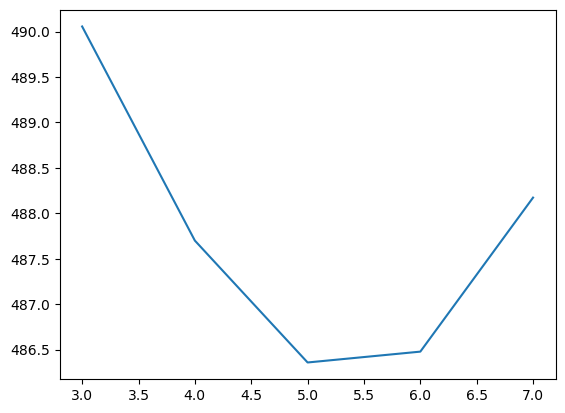

In [202]:
plt.plot(plot_dict.keys(), plot_dict.values())

In [204]:
plot_dict = {}
n_estimators = range(80, 220, 20)
for i in n_estimators:
    rmse, std = get_rmse(FEATURES, add_feature_train, n=i)
    plot_dict[i] = rmse
    print(f'n_estimators={i} rmse_cv={rmse:.3f} ({std:.3f})')

n_estimators=80 rmse_cv=487.039 (5.047)
n_estimators=100 rmse_cv=486.335 (5.110)
n_estimators=120 rmse_cv=485.955 (5.085)
n_estimators=140 rmse_cv=485.694 (5.201)
n_estimators=160 rmse_cv=485.712 (5.177)
n_estimators=180 rmse_cv=485.703 (5.201)
n_estimators=200 rmse_cv=485.647 (5.094)


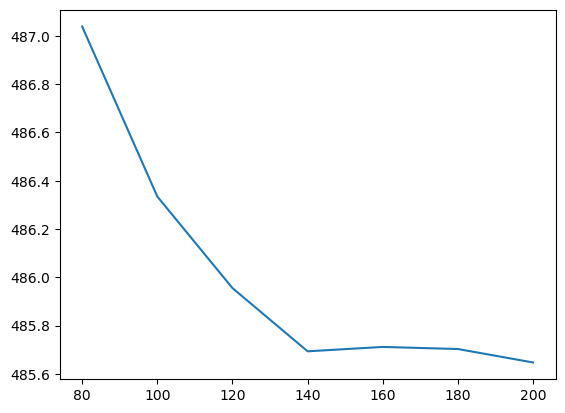

In [205]:
plt.plot(plot_dict.keys(), plot_dict.values())

## Residual Analysis

In [206]:
def preprocess_data(df):
    df = remove_duplicates(df)
    df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    df = remove_train_outliers(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    df = get_information_mrt(df, mrt_existing)
    df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date'])
    df = link_coe_and_rent(df, coe_price, 'a')
    return df

In [207]:
def preprocess_test_data(df):
    #df = remove_duplicates(df)
    #df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    #df = remove_train_outliers(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    df = get_information_mrt(df, mrt_existing)
    df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date'])
    df = link_coe_and_rent(df, coe_price, 'a')
    return df

In [244]:
param = 5
n = 140
target = 'street_name'
FEATURES = [
    'rent_approval_year', 
    'street_name', 
    'floor_area_sqm', 
    'coe_price', 
    'town', 
    'lease_commence_date', 
    'latitude', 
    'distance_to_nearest_mrt', 
    'flat_type', 
    'subzone_margaret drive', 
    'mrt_Bishan',
]

In [245]:
%%time
processed_train = preprocess_data(train)
add_feature_train, _= add_new_features(processed_train)

CPU times: user 36.9 s, sys: 226 ms, total: 37.1 s
Wall time: 37.3 s


In [246]:
%%time
df_X = add_feature_train[FEATURES]
df_y = add_feature_train['monthly_rent']
regressor = GradientBoostingRegressor(max_depth=param, n_estimators=n)

X_train = df_X.copy()
y_train = df_y.copy()
train_sub = pd.concat([X_train, y_train], axis=1)
target_dict, encoded_train = apply_target_encoding(train_sub, target)
encoded_train.drop(columns=[target, 'monthly_rent'], inplace=True)
        
numerical_train = convert_df_to_numeric(encoded_train)
array_train_X = numerical_train.to_numpy()
array_train_y = y_train.to_numpy()
    
# train
regressor.fit(array_train_X, array_train_y)
y_train_hat = regressor.predict(array_train_X)

CPU times: user 21.8 s, sys: 129 ms, total: 22 s
Wall time: 22.1 s


In [229]:
evaluation = processed_train.copy()
evaluation['prediction'] = y_train_hat
evaluation['residual'] = evaluation['prediction'] - evaluation['monthly_rent']

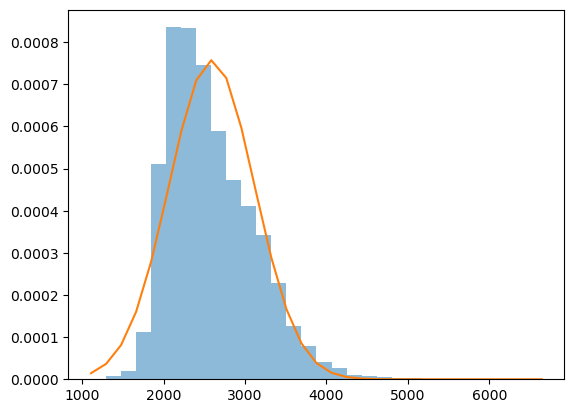

In [230]:
_, bins, _ = plt.hist(evaluation['prediction'], 30, density=1, alpha=0.5)

mu, sigma = scipy.stats.norm.fit(evaluation['prediction'])
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

plt.show()

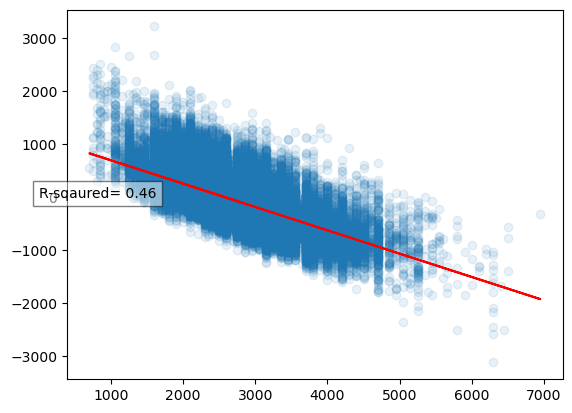

In [227]:
x = evaluation['monthly_rent']
y = evaluation['residual']
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept
residuals = y - y_pred
ss_residual = np.sum(residuals**2)
ss_total = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_residual / ss_total)

plt.scatter(evaluation['monthly_rent'], evaluation['residual'], alpha=0.1)
plt.plot(x, slope*x + intercept, color='red')
plt.text(0.5, 5.5, f'R-sqaured= {r_squared:.2f}', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

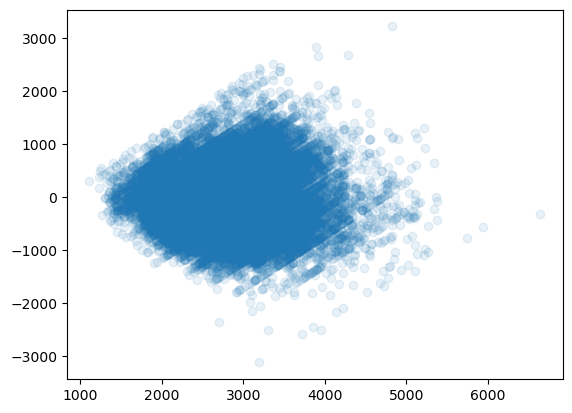

In [228]:
plt.scatter(evaluation['prediction'], evaluation['residual'], alpha=0.1)
plt.show()

In [233]:
evaluation.sort_values(by='residual').head(20)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,...,mrt_Ang Mo Kio,mrt_Serangoon,mrt_Queestown,mrt_Sembawang,mrt_Commonwealth,mrt_Toa Payoh,mrt_Bedok,central_and_large,prediction,residual
29061,2023-05-01,jurong west,457,jurong west street 41,4 room,model a,102.0,1984,1.350698,103.720905,...,0,0,0,0,0,0,0,0,3186.939296,-3113.060704
30715,2023-06-01,jurong west,628,jurong west street 65,executive,apartment,130.0,2001,1.342204,103.699448,...,0,0,0,0,0,0,0,0,3715.847841,-2584.152159
34824,2023-03-01,jurong east,216,Jurong East Street 21,executive,maisonette,148.0,1985,1.339531,103.737809,...,0,0,0,0,0,0,0,0,3948.164543,-2501.835457
42715,2022-11-01,hougang,539,hougang street 52,executive,maisonette,147.0,1992,1.377480,103.890340,...,0,0,0,0,0,0,0,0,3304.873803,-2495.126197
53281,2023-01-01,bukit merah,25,Lim Liak Street,3 room,standard,88.0,1973,1.285410,103.831281,...,0,0,0,0,0,0,0,0,3850.224268,-2449.775732
33251,2022-10-01,jurong west,501,jurong west street 51,3 room,model a,74.0,1986,1.350384,103.719026,...,0,0,0,0,0,0,0,0,2706.897081,-2343.102919
52666,2023-04-01,bukit merah,104b,depot road,5 room,improved,116.0,2000,1.280491,103.812101,...,0,0,0,0,0,0,0,0,4139.404822,-2160.595178
45149,2022-12-01,pasir ris,198,Pasir Ris Street 12,5 room,improved,124.0,1993,1.366973,103.960009,...,0,0,0,0,0,0,0,0,3100.812249,-2149.187751
15307,2022-10-01,kallang/whampoa,117b,Jalan Tenteram,4 room,model a,93.0,2017,1.328165,103.860802,...,0,0,0,0,0,0,0,0,4218.692913,-2081.307087
25456,2022-10-01,hougang,698d,hougang street 52,executive,apartment,141.0,1999,1.375637,103.888739,...,0,0,0,0,0,0,0,0,3202.304113,-2047.695887


In [234]:
evaluation.iloc[53281]

rent_approval_date           2023-01-01 00:00:00
town                                 bukit merah
block                                         25
street_name                      Lim Liak Street
flat_type                                 3 room
flat_model                              standard
floor_area_sqm                              88.0
lease_commence_date                         1973
latitude                                 1.28541
longitude                             103.831281
subzone                              tiong bahru
planning_area                        bukit merah
region                            central region
monthly_rent                                6300
rent_approval_year                          2023
rent_approval_month                            1
house_age                                     50
mrt_existing_count_1km                         3
mrt_planned_count_1km                          0
primary_schools_count_1km                      1
shopping_malls_count

In [236]:
mask = (evaluation['subzone'] == 'tiong bahru') & (evaluation['floor_area_sqm']<=90) & (evaluation['street_name'] == 'Lim Liak Street')
evaluation[mask].sort_values(by='monthly_rent', ascending=False)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,...,mrt_Ang Mo Kio,mrt_Serangoon,mrt_Queestown,mrt_Sembawang,mrt_Commonwealth,mrt_Toa Payoh,mrt_Bedok,central_and_large,prediction,residual
53281,2023-01-01,bukit merah,25,Lim Liak Street,3 room,standard,88.0,1973,1.285410,103.831281,...,0,0,0,0,0,0,0,0,3850.224268,-2449.775732
36279,2023-05-01,bukit merah,21,Lim Liak Street,3 room,standard,88.0,1973,1.285438,103.832161,...,0,0,0,0,0,0,0,0,3934.665112,584.665112
18958,2022-04-01,bukit merah,33,Lim Liak Street,3 room,standard,75.0,1973,1.285119,103.831577,...,0,0,0,0,0,0,0,0,2502.380925,-247.619075


In [259]:
mask = (evaluation['subzone'] == 'tiong bahru') & (evaluation['floor_area_sqm']<=90) & (evaluation['rent_approval_year'] == 2023)
columns = [i for i in train.columns if not i in ['elevation', 'furnished']] + ['prediction', 'residual']
evaluation.loc[mask, columns].sort_values(by='monthly_rent', ascending=False)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,monthly_rent,prediction,residual
2696,2023-04-01,bukit merah,21,lim liak street,3 room,standard,88.0,1973,1.285438,103.832161,tiong bahru,bukit merah,central region,6500,5106.213664,-1393.786336
53281,2023-01-01,bukit merah,25,Lim Liak Street,3 room,standard,88.0,1973,1.285410,103.831281,tiong bahru,bukit merah,central region,6300,3850.224268,-2449.775732
27622,2023-02-01,bukit merah,19,lim liak street,3 room,standard,88.0,1973,1.285494,103.832600,tiong bahru,bukit merah,central region,5800,5007.556053,-792.443947
44274,2023-05-01,bukit merah,10b,Boon Tiong Road,4 room,model a,87.0,2016,1.286337,103.829205,tiong bahru,bukit merah,central region,5250,4443.380142,-806.619858
15415,2023-07-01,bukit merah,38,kim pong road,3 room,standard,75.0,1974,1.284865,103.830500,tiong bahru,bukit merah,central region,5250,3943.626767,-1306.373233
14443,2023-03-01,bukit merah,37,lim liak street,3 room,standard,88.0,1974,1.285084,103.830494,tiong bahru,bukit merah,central region,5150,4809.185879,-340.814121
15697,2023-04-01,bukit merah,34,Kim Cheng Street,3 room,standard,88.0,1973,1.284899,103.831584,tiong bahru,bukit merah,central region,5050,4669.856425,-380.143575
52648,2023-06-01,bukit merah,29,lim liak street,3 room,standard,88.0,1973,1.285381,103.830401,tiong bahru,bukit merah,central region,5000,4842.710366,-157.289634
59449,2023-07-01,bukit merah,25,lim liak street,3 room,standard,88.0,1973,1.285410,103.831281,tiong bahru,bukit merah,central region,4700,4785.404157,85.404157
48133,2023-05-01,bukit merah,34,Kim Cheng Street,3 room,standard,88.0,1973,1.284899,103.831584,tiong bahru,bukit merah,central region,4700,4675.727510,-24.272490


In [261]:
mask = (evaluation['flat_type'] == '3 room') & (evaluation['floor_area_sqm']>=80)
evaluation.loc[mask, columns].sort_values(by='monthly_rent', ascending=False).head(20)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,monthly_rent,prediction,residual
49959,2022-11-01,bukit merah,35,lim liak street,3 room,standard,88.0,1973,1.285102,103.831035,tiong bahru,bukit merah,central region,6500,5742.345656,-757.654344
2696,2023-04-01,bukit merah,21,lim liak street,3 room,standard,88.0,1973,1.285438,103.832161,tiong bahru,bukit merah,central region,6500,5106.213664,-1393.786336
53281,2023-01-01,bukit merah,25,Lim Liak Street,3 room,standard,88.0,1973,1.285410,103.831281,tiong bahru,bukit merah,central region,6300,3850.224268,-2449.775732
27622,2023-02-01,bukit merah,19,lim liak street,3 room,standard,88.0,1973,1.285494,103.832600,tiong bahru,bukit merah,central region,5800,5007.556053,-792.443947
14443,2023-03-01,bukit merah,37,lim liak street,3 room,standard,88.0,1974,1.285084,103.830494,tiong bahru,bukit merah,central region,5150,4809.185879,-340.814121
15697,2023-04-01,bukit merah,34,Kim Cheng Street,3 room,standard,88.0,1973,1.284899,103.831584,tiong bahru,bukit merah,central region,5050,4669.856425,-380.143575
52648,2023-06-01,bukit merah,29,lim liak street,3 room,standard,88.0,1973,1.285381,103.830401,tiong bahru,bukit merah,central region,5000,4842.710366,-157.289634
24096,2022-11-01,queenstown,55,Stirling Road,3 room,terrace,87.0,1968,1.296589,103.804175,mei chin,queenstown,central region,4850,3939.651642,-910.348358
59449,2023-07-01,bukit merah,25,lim liak street,3 room,standard,88.0,1973,1.285410,103.831281,tiong bahru,bukit merah,central region,4700,4785.404157,85.404157
48133,2023-05-01,bukit merah,34,Kim Cheng Street,3 room,standard,88.0,1973,1.284899,103.831584,tiong bahru,bukit merah,central region,4700,4675.727510,-24.272490


In [263]:
mask = (evaluation['street_name'].str.lower()>='pasir ris drive 10')
evaluation.loc[mask, columns].sort_values(by='monthly_rent', ascending=False).head(20)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,monthly_rent,prediction,residual
53474,2022-12-01,bukit merah,17,seng poh road,4 room,standard,110.0,1973,1.285297,103.833235,tiong bahru,bukit merah,central region,6500,5944.358200,-555.641800
21967,2023-07-01,bukit merah,67,telok blangah drive,5 room,standard,118.0,1978,1.274637,103.809633,telok blangah drive,bukit merah,central region,5900,4065.164457,-1834.835543
31339,2022-12-01,bukit merah,93b,telok blangah street 31,4 room,model a,93.0,2018,1.275357,103.807977,telok blangah drive,bukit merah,central region,5800,4478.192471,-1321.807529
17801,2023-07-01,jurong east,277,toh guan road,5 room,improved,121.0,1998,1.341319,103.746726,toh guan,jurong east,west region,5650,3847.328732,-1802.671268
50632,2023-06-01,jurong east,285d,Toh Guan Road,executive,apartment,143.0,1998,1.337890,103.746039,toh guan,jurong east,west region,5600,4075.459349,-1524.540651
10593,2023-06-01,jurong east,285d,toh guan road,executive,apartment,143.0,1998,1.337890,103.746039,toh guan,jurong east,west region,5450,4075.459349,-1374.540651
34282,2023-01-01,yishun,665,yishun avenue 4,executive,apartment,181.0,1992,1.419783,103.840574,yishun south,yishun,north region,5450,4095.674302,-1354.325698
58002,2023-07-01,bukit merah,93b,Telok Blangah Street 31,4 room,model a,93.0,2018,1.275357,103.807977,telok blangah drive,bukit merah,central region,5400,5035.330540,-364.669460
40052,2023-07-01,choa chu kang,120,teck whye lane,executive,maisonette,146.0,1989,1.378842,103.750341,teck whye,choa chu kang,west region,5250,3727.627246,-1522.372754
3957,2023-05-01,bukit merah,82,redhill lane,5 room,improved,131.0,1996,1.287416,103.819475,redhill,bukit merah,central region,5250,4235.486449,-1014.513551


In [266]:
flat_type_mask = evaluation['flat_type'] == '4 room'
floor_size_mask = evaluation['floor_area_sqm'] >= 110
evaluation[flat_type_mask & floor_size_mask].monthly_rent.describe()

count     530.000000
mean     2684.528302
std       687.387223
min      1450.000000
25%      2100.000000
50%      2500.000000
75%      3150.000000
max      6500.000000
Name: monthly_rent, dtype: float64

In [267]:
flat_type_mask = evaluation['flat_type'] == '4 room'
floor_size_mask = evaluation['floor_area_sqm'] >= 110
evaluation[flat_type_mask].monthly_rent.describe()

count    21805.000000
mean      2692.827333
std        706.135421
min        750.000000
25%       2150.000000
50%       2500.000000
75%       3150.000000
max       6500.000000
Name: monthly_rent, dtype: float64

# for Kaggle

In [247]:
%%time
test = pd.read_csv('test.csv')
processed_test = preprocess_test_data(test)
add_feature_test, _ = add_new_features(processed_test)
selected_feature_test = add_feature_test[FEATURES]
encoded_test = encode_test_set(selected_feature_test, target, target_dict)
numerical_test = convert_df_to_numeric(encoded_test)
array_test_X = numerical_test.to_numpy()

CPU times: user 18.3 s, sys: 100 ms, total: 18.4 s
Wall time: 18.5 s


In [248]:
%%time
y_hat = regressor.predict(array_test_X)
get_csv_for_kaggle(y_hat, f'prediction_final_kaggle.csv')

CPU times: user 244 ms, sys: 6.97 ms, total: 251 ms
Wall time: 251 ms


RMSE_test = 482.65684